In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

def grid_finder(X_grid, Y_grid, ic, jc, r):
    center_x = X_grid[ic, jc]
    i_left = 0
    while center_x - X_grid[ic - i_left, jc] < r:
        i_left += 1

    i_right = 0
    while X_grid[ic + i_right, jc] - center_x < r:
        i_right += 1

    center_y = Y_grid[ic, jc]
    j_down = 0
    while center_y - Y_grid[ic, jc - j_down] < r:
        j_down += 1

    j_up = 0
    while Y_grid[ic, jc + j_up] - center_y < r:
        j_up += 1

    return i_left, i_right, j_down, j_up


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


### Vertical Dataset of Centers

In [3]:
def dopioe(ic, jc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    center_x = X[ic, jc]

    i_left = 0
    left_x = X[ic - i_left, jc]
    while center_x - left_x < r:
        i_left += 1
        left_x = X[ic - i_left, jc]
        
    i_right = 0
    right_x = X[ic + i_right, jc]
    while right_x - center_x < r:
        i_right += 1
        right_x = X[ic + i_right, jc]

    u1 = u[ic - i_left: ic + i_right + 1, jc]
    v1 = v[ic - i_left: ic + i_right + 1, jc]
    x1 = X[ic - i_left: ic + i_right + 1, jc]
    y1 = Y[ic - i_left: ic + i_right + 1, jc]
        
    xx = x1 - center_x

    # Horizontal profile along row nic
    center_y = Y[ic, jc]

    j_down = 0
    down_y = Y[ic, jc - j_down]
    while center_y - down_y < r:
        j_down += 1
        down_y = Y[ic, jc - j_down]
        
    j_up = 0
    up_y = Y[ic, jc + j_up]
    while up_y - center_y < r:
        j_up += 1
        up_y = Y[ic, jc + j_up]
    
    u2 = u[ic, jc - j_down: jc + j_up + 1]
    v2 = v[ic, jc - j_down: jc + j_up + 1]
    x2 = X[ic, jc - j_down: jc + j_up + 1]
    y2 = Y[ic, jc - j_down: jc + j_up + 1]

    yy = y2 - center_y

    # print(i_left, i_right, j_down, j_up)

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q
    

#### Sample
AE Downstream: 2749, 8
\
AE Upstream: 2504, 896
\
CE Downstream: 1394, 382
\
CE Upstream: 1967, 926 (reasonable)


In [7]:
def compute_df_tilt(df_eddies, eddy, t, X_grid, Y_grid, z_r, dopioe):

    data = df_eddies[df_eddies['ID'] == eddy].iloc[t]
    day, fname, xc_surf, yc_surf, w_surf = data['Day'], data['fname'], data['x0'], data['y0'], data['w']
    fnumber = fname[-8:-3]

    u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
    v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')

    u_raw = np.where(u_raw > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(v_raw > 1e30, np.nan, v_raw).astype(float)

    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    t_rel = np.where(ocean_time == day)[0][0]

    u_t, v_t = u_raw[:, :, :, t_rel].squeeze(), v_raw[:, :, :, t_rel].squeeze()

    df_tilt = pd.DataFrame(columns=['x', 'y', 'Q', 'w', 'z', 'Depth'])
    x0, y0 = xc_surf, yc_surf

    for k in range(24):
        u = u_t[:, :, k].squeeze()
        v = v_t[:, :, k].squeeze()

        u = np.where(u > 1e30, np.nan, u).astype(float)
        v = np.where(v > 1e30, np.nan, v).astype(float)

        R = np.hypot(x0 - X_grid, y0 - Y_grid)
        ic, jc = np.where(R == np.min(R))
        ic, jc = int(ic[0]), int(jc[0])

        r = 20
        x0, y0, w, Q = dopioe(ic, jc, r, u, v, X_grid, Y_grid)

        if np.sign(w) == np.sign(w_surf):
            df_tilt.loc[len(df_tilt)] = {'x': x0, 'y': y0, 'Q': Q, 'w': w, 'z': k, 'Depth': z_r[150, 150, k]}
        else:
            break

    df_tilt['TD'] = np.hypot(df_tilt['x'] - df_tilt.iloc[0]['x'], df_tilt['y'] - df_tilt.iloc[0]['y'])
    df_tilt['Grad'] = df_tilt['y'].diff() / df_tilt['x'].diff()

    return df_tilt, u_t, v_t


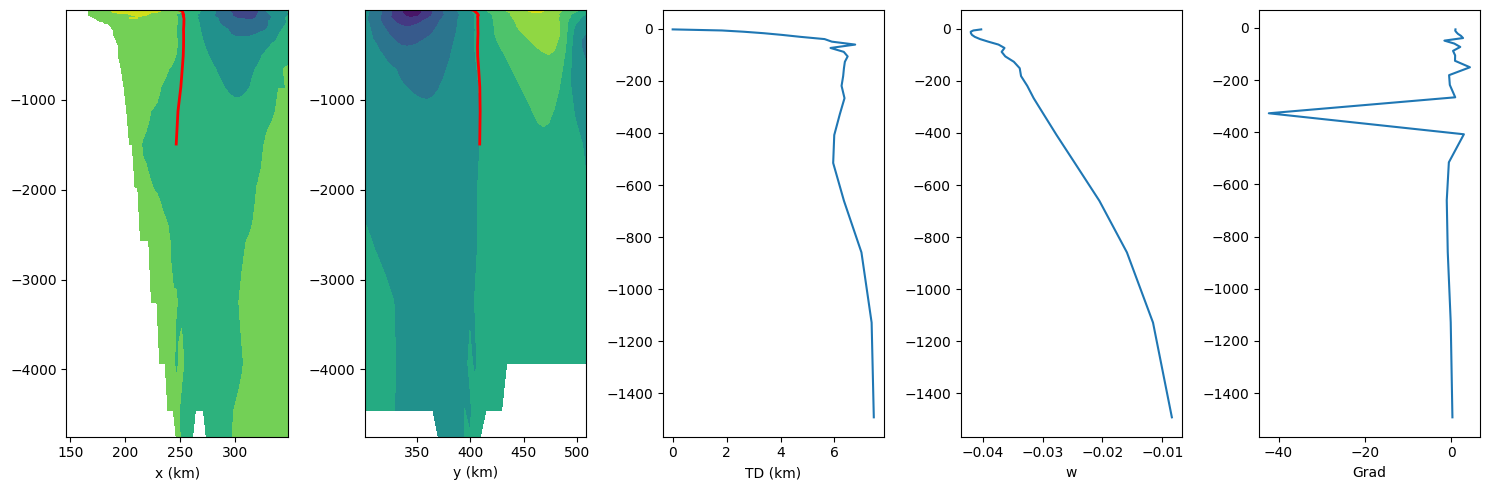

In [16]:
eddy = 1394
t = 50
df_tilt, u_t, v_t = compute_df_tilt(df_eddies, eddy, t, X_grid, Y_grid, z_r, dopioe)

data = df_eddies[df_eddies['ID']==eddy].iloc[t]
xc_surf, yc_surf, ic_surf, jc_surf = data['x0'], data['y0'], data['ic'], data['jc']

r = 100
i_left, i_right, j_down, j_up = grid_finder(X_grid, Y_grid, ic_surf, jc_surf, r)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

vmin, vmax = None, None
axs[0].contourf(x_grid[ic_surf-i_left:ic_surf+i_right+1], z_r[150,150,:], u_t[ic_surf-i_left:ic_surf+i_right+1, jc_surf, :].T, vmin=vmin, vmax=vmax)
axs[0].plot(df_tilt['x'], df_tilt['Depth'], 'r', linewidth=2)
axs[0].set_xlabel('x (km)')
axs[1].contourf(y_grid[jc_surf-j_down:jc_surf+j_up+1], z_r[150,150,:], u_t[ic_surf, jc_surf-j_down:jc_surf+j_up+1, :].T, vmin=vmin, vmax=vmax)
axs[1].plot(df_tilt['y'], df_tilt['Depth'], 'r', linewidth=2)
axs[1].set_xlabel('y (km)')
axs[2].plot(df_tilt['TD'], df_tilt['Depth'])
axs[2].set_xlabel('TD (km)')
axs[3].plot(df_tilt['w'], df_tilt['Depth'])
axs[3].set_xlabel('w')
axs[4].plot(df_tilt['Grad'], df_tilt['Depth'])
axs[4].set_xlabel('Grad')

plt.tight_layout()
plt.show()
